# Set up

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno
import random as rd

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPool2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten
#Image preprocessing
from keras.layers import Rescaling, Resizing, CenterCrop 
#Image augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def show_training_history(history, last_epoch = None):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
    if 'val_loss' in history.history:
        ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss', axes = ax[0])
    if last_epoch is not None:
        ax[0].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[0].legend(loc = 'best', shadow = True)
    ax[1].plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
    if 'val_accuracy' in history.history:
        ax[1].plot(history.history['val_accuracy'], color = 'r',label = 'Validation accuracy')
    if last_epoch is not None:
        ax[1].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[1].legend(loc = 'best', shadow = True)
    plt.show()

In [6]:
def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

# Dataset

In [7]:
df = pd.read_csv('__datasets/Synthetic_Dataset.csv')
df

,x01,x02,x03,x04,x05,...,x07,x08,x09,x10,class
0,69.659807,-102.567490,-209.903964,6.472164,4.313487,...,-2.332122,-162.011126,157.151007,26.729849,0
1,-167.101860,-10.358355,-245.384592,-40.677900,0.273391,...,-88.687790,-31.520900,-49.678909,-6.353039,0
2,13.336421,-95.034657,-14.315424,220.731440,-0.768787,...,-10.678075,64.526753,-105.345817,108.155193,1
3,-22.264600,-104.296800,76.000002,-41.293515,-10.132445,...,33.234002,-70.546114,-4.324115,-83.161245,1
4,-48.277153,44.170234,165.491114,72.755204,4.191435,...,-7.188119,252.577423,41.923064,-102.622804,1
...,...,...,...,...,...,...,...,...,...,...,...
119995,69.019243,69.678800,-43.927496,-189.412705,-6.873485,...,-38.601989,-102.568423,58.869594,63.136282,2
119996,-56.719397,26.530471,-253.238920,104.530108,5.664701,...,-104.254184,42.196204,133.678476,161.542990,0
119997,-12.006466,-67.594048,-57.671303,-246.153987,-8.788019,...,-16.214359,-138.868499,-90.248863,-158.980527,1
119998,-73.004201,-158.295355,-249.423123,-28.372124,-1.720927,...,20.457649,-279.423463,50.368413,-30.839177,0


In [8]:
x = df.drop(columns = ['class'])
y = df['class']

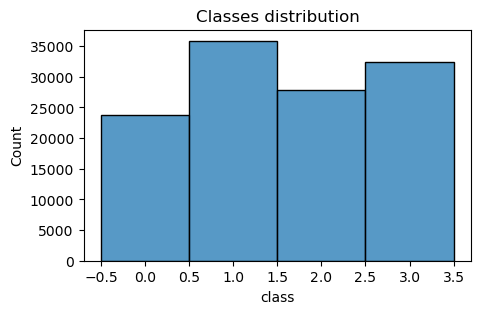

In [9]:
plt.figure(figsize = (5, 3))
plt.title('Classes distribution')
sb.histplot(y, discrete = True)
plt.show()

# Preprocessing

In [10]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[ 0.49596339, -0.9876935 , -0.99913933, ..., -1.08764514,
         2.09491062,  0.15249265],
       [-1.19631555,  0.18329399, -1.17115655, ..., -0.10942355,
        -0.66307068, -0.17702829],
       [ 0.09338606, -0.89203213, -0.0508868 , ...,  0.61059886,
        -1.40536316,  0.96352693],
       ...,
       [-0.0877549 , -0.54355678, -0.26108481, ..., -0.91415615,
        -1.20405227, -1.697269  ],
       [-0.52374263, -1.69539598, -1.19073616, ..., -1.96782816,
         0.6710141 , -0.42092161],
       [-0.89280642,  0.12864389,  0.50495806, ..., -0.59048339,
         1.43681208, -1.28165639]])

# Train, test and validation sets

In [11]:
x_train_, x_test, y_train_, y_test = train_test_split(x_scaled, y, test_size = 0.20, random_state = 42, shuffle = True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.05, random_state = 42)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_validation_categorical = to_categorical(y_validation)
print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print(f'y train categorical: {y_train_categorical.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print(f'y test categorical: {y_test_categorical.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')
print(f'y validation categorical: {y_validation_categorical.shape}')

x train: (91200, 10)
y train: (91200,)
y train categorical: (91200, 4)

x test: (24000, 10)
y test: (24000,)
y test categorical: (24000, 4)

x validation: (4800, 10)
y validation: (4800,)
y validation categorical: (4800, 4)


# Classification with multilayer perceptron

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                550       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                2

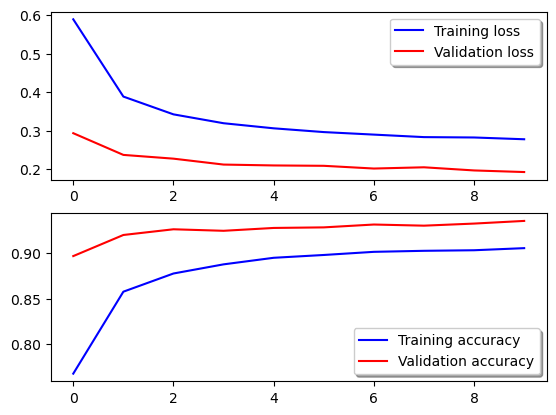

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4692
           1       0.93      0.93      0.93      7144
           2       0.92      0.94      0.93      5627
           3       0.94      0.94      0.94      6537

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000



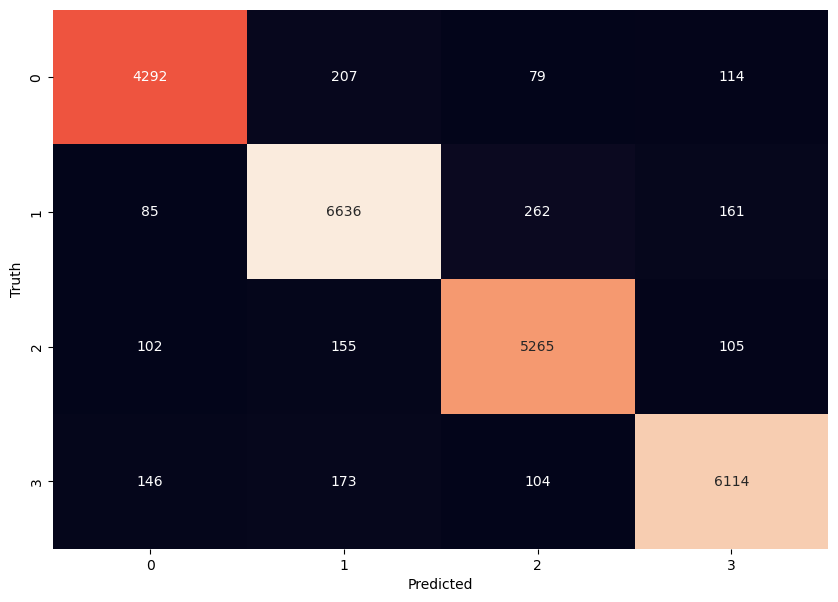

In [12]:
perceptron = Sequential([
    Dense(50, activation = 'relu', input_dim = x_train.shape[1]),
    Dropout(0.15),
    Dense(50, activation = 'relu'),
    Dropout(0.20),
    Dense(50, activation = 'relu'),
    Dropout(0.25),
    Dense(50, activation = 'relu'),
    Dense(y_train_categorical.shape[1], activation = 'softmax')
])
perceptron.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(perceptron.summary())

epochs = 10
batch_size = 32
perceptron_history = perceptron.fit(
    x_train, 
    y_train_categorical, 
    validation_data = (x_validation, y_validation_categorical),
    batch_size = batch_size,
    epochs = epochs)

loss, accuracy = perceptron.evaluate(x_test, y_test_categorical)  

print('---------')
print(f'Accuracy: {accuracy}, loss: {loss}')
print('---------')

show_training_history(perceptron_history)
y_predicted_from_perceptron = np.argmax(perceptron.predict(x_test), axis = 1)
print(classification_report(y_test, y_predicted_from_perceptron))
show_confusion_matrix(y_test, y_predicted_from_perceptron)

# PCA

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
pca_x = pca.fit_transform(x_scaled)
pca_x

array([[ 1.17810424, -0.49631389, -0.23229827, -2.06465565,  0.92516965],
       [ 1.83490166, -0.7471729 , -0.59395585, -0.01399233, -0.88884256],
       [-0.59679061, -0.99084362,  0.04708561,  0.5066197 , -1.46170754],
       ...,
       [ 2.25042691,  1.55088299,  0.41373239,  1.18905559, -0.54798224],
       [ 2.2687443 , -0.16212225,  0.91696245,  0.3285767 ,  1.14386985],
       [ 1.18562923,  1.90742521,  1.27237284, -0.39350505,  1.5214563 ]])

In [14]:
per_var = np.round(pca.explained_variance_ratio_ * 100.0, decimals = 4)
labels = [str(i) for i in range(1, len(per_var) + 1)]
print(f'Explained varience: {np.sum(per_var)}')

Explained varience: 79.7746


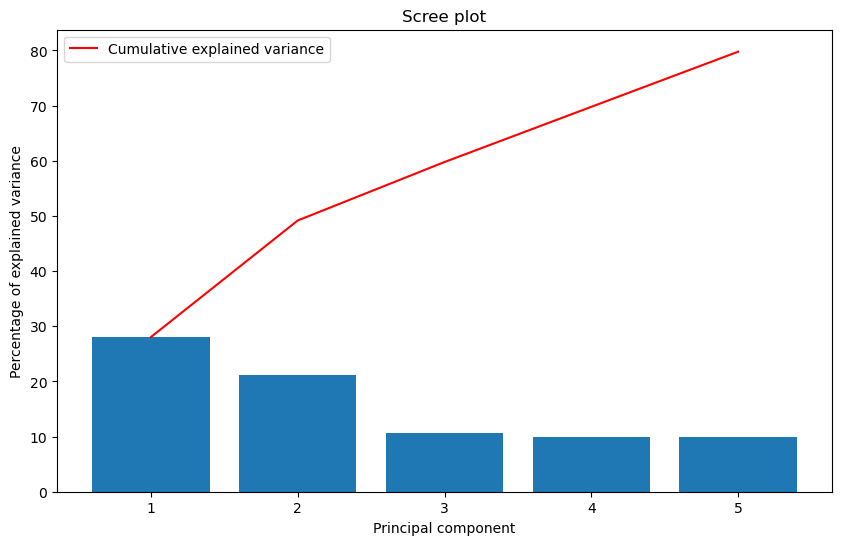

In [15]:
plt.figure(figsize = (10, 6))
plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
plt.plot(range(1, len(per_var) + 1), np.cumsum(per_var), c = 'red', label = 'Cumulative explained variance')
plt.legend(loc = 'upper left')
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal component')
plt.title('Scree plot')
plt.show()

## Train, test and validation sets (PCA)

In [16]:
pca_x_train_, pca_x_test, pca_y_train_, pca_y_test = train_test_split(pca_x, y, test_size = 0.20, random_state = 42, shuffle = True)
pca_x_train, pca_x_validation, pca_y_train, pca_y_validation = train_test_split(pca_x_train_, pca_y_train_, test_size = 0.05, random_state = 42)
pca_y_train_categorical = to_categorical(pca_y_train)
pca_y_test_categorical = to_categorical(pca_y_test)
pca_y_validation_categorical = to_categorical(pca_y_validation)
print(f'x train: {pca_x_train.shape}')
print(f'y train: {pca_y_train.shape}')
print(f'y train validation: {pca_y_train_categorical.shape}')
print()
print(f'x test: {pca_x_test.shape}')
print(f'y test: {pca_y_test.shape}')
print(f'y test validation: {pca_y_test_categorical.shape}')
print()
print(f'x validation: {pca_x_validation.shape}')
print(f'y validation: {pca_y_validation.shape}')
print(f'y validation validation: {pca_y_validation_categorical.shape}')

x train: (91200, 5)
y train: (91200,)
y train validation: (91200, 4)

x test: (24000, 5)
y test: (24000,)
y test validation: (24000, 4)

x validation: (4800, 5)
y validation: (4800,)
y validation validation: (4800, 4)


## Classification with MLP (PCA)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                300       
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 50)               

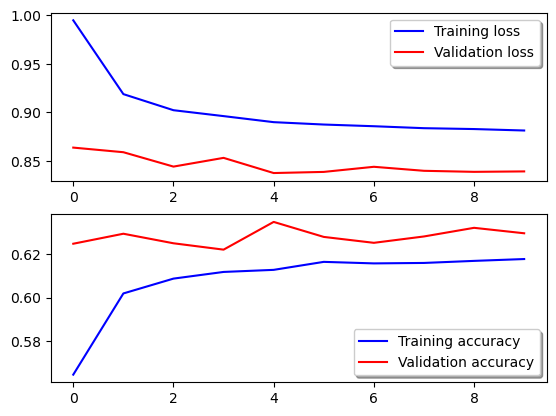

              precision    recall  f1-score   support

           0       0.57      0.48      0.53      4692
           1       0.60      0.74      0.66      7144
           2       0.73      0.53      0.62      5627
           3       0.63      0.68      0.66      6537

    accuracy                           0.63     24000
   macro avg       0.63      0.61      0.62     24000
weighted avg       0.63      0.63      0.62     24000



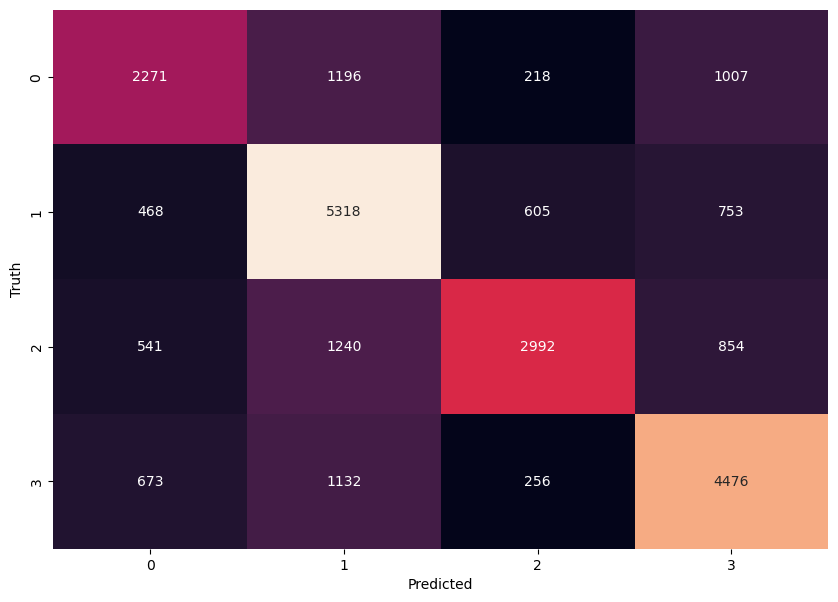

In [17]:
pca_perceptron = Sequential([
    Dense(50, activation = 'relu', input_dim = pca_x_train.shape[1]),
    Dropout(0.15),
    Dense(50, activation = 'relu'),
    Dropout(0.20),
    Dense(50, activation = 'relu'),
    Dropout(0.25),
    Dense(50, activation = 'relu'),
    Dense(pca_y_train_categorical.shape[1], activation = 'softmax')
])
pca_perceptron.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(pca_perceptron.summary())

epochs = 10
batch_size = 32
pca_perceptron_history = pca_perceptron.fit(
    pca_x_train, 
    pca_y_train_categorical, 
    validation_data = (pca_x_validation, pca_y_validation_categorical),
    batch_size = batch_size,
    epochs = epochs)

loss, accuracy = pca_perceptron.evaluate(pca_x_test, pca_y_test_categorical)  

print('---------')
print(f'Accuracy: {accuracy}, loss: {loss}')
print('---------')

show_training_history(pca_perceptron_history)
y_predicted_from_pca_perceptron = np.argmax(pca_perceptron.predict(pca_x_test), axis = 1)
print(classification_report(pca_y_test, y_predicted_from_pca_perceptron))
show_confusion_matrix(pca_y_test, y_predicted_from_pca_perceptron)

# Decision regions

C:\Users\dexp\miniconda3\envs\env-tf\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


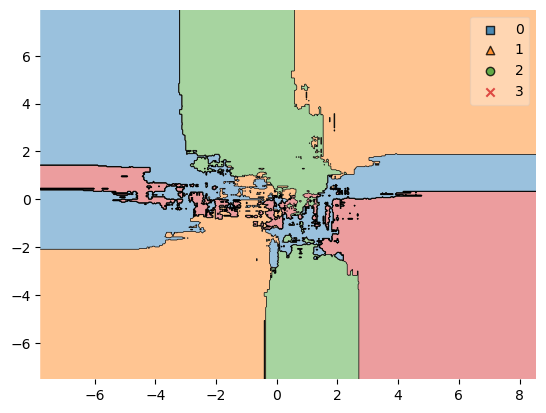

In [24]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions

forest = RandomForestClassifier()
forest.fit(pca_x_train, pca_y_train)

plot_decision_regions(
    pca_x_test,
    pca_y_test.to_numpy(),
    forest, #perceptron,
    feature_index = [0, 1],
    filler_feature_values = {2: 0, 3: 0, 4: 0},
    filler_feature_ranges = {2: 0, 3: 0, 4: 0})
    #filler_feature_values = {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    #filler_feature_ranges = {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0})
plt.show()